# Cuisine and Ingredients clustering

I have always been passionate about food and its polarity. Food can be the source of a strong and healthy life, as much as it can make you weak and sick. It can represent plain fuel for some people, or a form of artistic expression for others. It can be as simple as inserting a slice of cheese between 2 pieces of bread and as complicated as making a Michelin-star plate involving dozens of ingredients into very long and intricate processes. 
Having a meal is a whole experience we get so often yet can be so diverse. From getting a quick but heartwarming panini  sandwich for lunch on a busy workday, to sharing a relaxed Sunday roast with one's family.

For as long as there have been beings, food has been a vital element to promote life. It has evolved a lot across time.
From choosing plants to breed in specific conditions, processes to preserve food on long periods of time, processes to make food edible, techniques to increase productivity and food supply... The current state of agriculture is the heritage of millenniums of geographical, meteorological, social, and cultural factors.

With such diverse populations and landscapes around the world, we still share many similarity in the way we make and consume food. I am wondering if it is possible to witness historical and geographical similarity with the way we eat.
By clustering cuisines through their recipes, I hope to see common traits arise between cuisine from people with different ethnicity, but who share similar geographical conditions or between populations which ancestors have shared a past connection. Eventually, this approach could reveal unexpected similarities or differences between some cuisines.

To achieve this clustering effort, I have found a collection of pairs of recipe ingredients and cuisine origin. The data comes from [Yummly](https://www.yummly.com) , a recipe recommender website. The dataset contains about 40000 recipes from 20 regions. The aim is to use text processing techniques to then apply unsupervised Machine Learning techniques to find clusters of cuisines and ingredients. In the first part I will preprocess the text data, remove some stop words, and get it accessible to our following algorithms. In the second part I model the ingredients lists using 3 methods: K-Means, Principal Component Analysis (PCA) then a Latent Dirichlet Allocation (LDA) model in order to find cluster of ingredients and see if it is possible to group regional cuisines together or find regular pattern in the ingredients choice.

## Imports

In [112]:
# Basic Tools
import pandas as pd
import numpy as np
import mglearn
import itertools
import json
from IPython.display import display, HTML

# Visuals
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from PIL import Image
%matplotlib inline

# Machine Learning
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, KernelPCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [113]:
# Dataset of ingredients list associated with a region from Yummly. 
df = pd.read_json('./data/Yummly/train.json')


# Load previous Within Cluster Sum of Squares results (K-Means)
with open("wcss_kmeans_res_1-24.json", "r") as fp:
    wcss_1_24 = json.load(fp)

###### Graphs helper

In [114]:
# Labels prep
keys = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 
        'mexican', 'chinese', 'british', 'thai', 'vietnamese', 'cajun_creole', 'brazilian', 
        'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian']
color_vals = ['red', 'sienna', 'tan', 'gold', 'darkkhaki', 'chartreuse', 'darkgreen', 'darkcyan',
              'deepskyblue', 'royalblue', 'navy', 'darkorchid', 'mediumvioletred', 'grey', 'maroon',
              'coral', 'darkorange', 'olive', 'lightgreen','g']
colors = dict(zip(keys,color_vals))
markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8'] * 2

###### Functions

In [115]:
def add_top_column(df, top_col, inplace=False):
    if not inplace:
        df = df.copy()
    
    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

## Exploratory Data Analysis

In [116]:
print('Dataset shape: ', df.shape)
df.head()

Dataset shape:  (39774, 3)


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  39774 non-null  int64 
 1   cuisine             39774 non-null  object
 2   ingredients         39774 non-null  object
 3   ingredients_string  39774 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [117]:
# Unique cuisines
print('Number of different cuisines: ', len(df['cuisine'].unique()))

# Unique meals
print('Number of unique meals: ', sum(df['id'].value_counts()))

# Missing ingredient list
print('Missing set of ingredients: ', sum(df['ingredients'].isna()))

# Missing cuisine
print('Missing meal origin: ', sum(df['cuisine'].isna()))

Number of different cuisines:  20
Number of unique meals:  39774
Missing set of ingredients:  0
Missing meal origin:  0


In [118]:
# Count of recipes per cuisine
df['cuisine'].value_counts().to_frame().transpose()

,italian,mexican,southern_us,indian,chinese,french,cajun_creole,thai,japanese,greek,spanish,korean,vietnamese,moroccan,british,filipino,irish,jamaican,russian,brazilian
cuisine,7838,6438,4320,3003,2673,2646,1546,1539,1423,1175,989,830,825,821,804,755,667,526,489,467


In [164]:
df['cuisine'].value_counts().index

Index(['italian', 'mexican', 'southern_us', 'indian', 'chinese', 'french',
       'cajun_creole', 'thai', 'japanese', 'greek', 'spanish', 'korean',
       'vietnamese', 'moroccan', 'british', 'filipino', 'irish', 'jamaican',
       'russian', 'brazilian'],
      dtype='object')

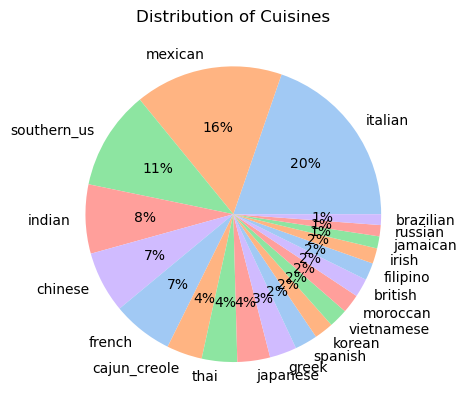

In [168]:
# values to plot
val = df['cuisine'].value_counts().values
ind = df['cuisine'].value_counts().index

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(val, labels = ind, colors = colors, autopct='%.0f%%')
plt.title('Distribution of Cuisines')
plt.show()

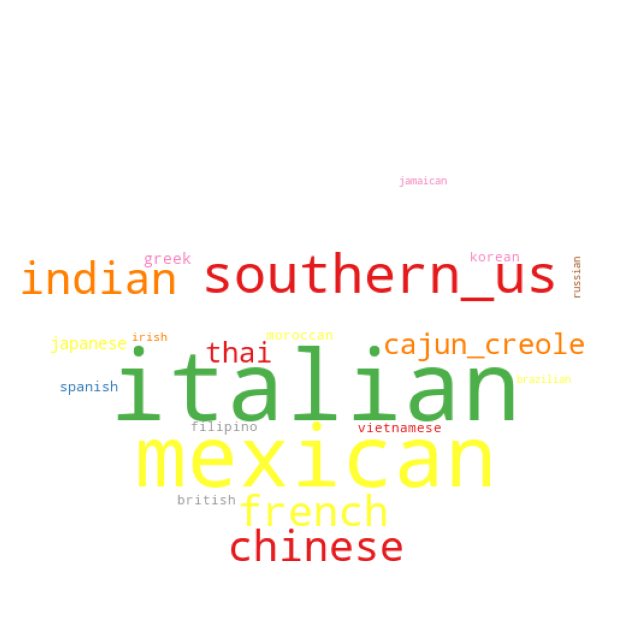

In [102]:
# Cuisine wordcloud

# Import bowl shape
bowl_mask = np.array(Image.open('./img/bowl.png'))

# Wordcloud
plt.subplots(figsize = (8,8))
wordcloud = WordCloud (
                    background_color = 'white',
                    width = 712,
                    height = 384,
                    mask=bowl_mask,
                    colormap = 'Set1').generate(' '.join(df['cuisine'].values))
plt.imshow(wordcloud) 
plt.axis('off') # remove axis
#plt.savefig('./img/cuisines.png')
plt.show()

The data contains mostly Italian, Mexican, Southern US, Indian, Chinese & French cuisine. It is not hard to guess that the data comes from an American website with such food influences. <br> 
The recipes are not equally distributed among all regions but there still are at least 467 lists of ingredients for each region. 

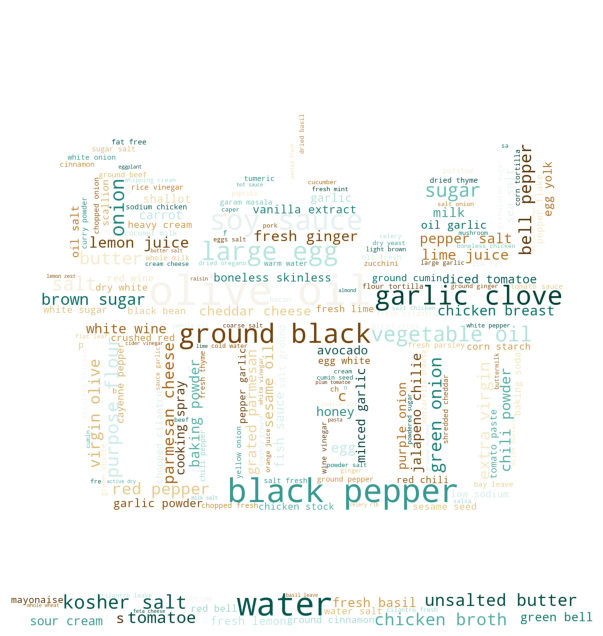

In [106]:
# Ingredients wordcloud

# Import basket shape
basket_mask = np.array(Image.open('./img/basket.png'))

plt.subplots(figsize = (10,8))
wordcloud = WordCloud (
                    background_color = 'white',
                    width = 712,
                    height = 384,
                    mask=basket_mask,
                    colormap = 'BrBG').generate(df['ingredients'].str.join(' ').to_string())
plt.imshow(wordcloud) 
plt.axis('off') # remove axis
#plt.savefig('./img/ingredients.png')
plt.show()

In [145]:
pd.Series([x for item in df['ingredients'] for x in item]).value_counts()[0:20].to_frame(name='Count')

,Count
salt,18049
olive oil,7972
onions,7972
water,7457
garlic,7380
sugar,6434
garlic cloves,6237
butter,4848
ground black pepper,4785
all-purpose flour,4632


We can see that among ingredients, spices and condiments appear very often, it is expected as they are fundamental ingredients in most recipes. We can also observe some ingredients that symbolic of some specific cuisines: lime juice, parmesan cheese, soy sauce, jalapeno chili, green onion... These ingredients are specific to some regions and so I expect them to be markers of cuisines. 

## Text processing

In this part, we will apply some text vectorizing tools so that further algorithms can use the ingredients as inputs.

### Text preprocessing

We start by changing the lists of ingredients to a set of strings.

In [119]:
# Ingredients as string to apply TfidVectorizer
df['ingredients_string'] = df['ingredients'].str.join(' ')
df.head()

,id,cuisine,ingredients,ingredients_string
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


We can now regroup all the ingredients present in the recipes and apply the TF-IDF algorithm to get a measure of the importance of each ingredients in the whole corpus

In [120]:
# Corpus of ingredients lists
list_corpus = df['ingredients_string'].tolist()

# Initiate TF-IDF
vectorizer = TfidfVectorizer()

# Fit TF-IDF
vectorizer.fit(list_corpus)

# Matrix of TF-IDF features
vector = vectorizer.transform(df['ingredients_string'])

We can rank the words by both IDF and TF-IDF scores

In [121]:
# Column-wise max values
max_value = vector.max(axis=0).toarray().ravel()

# Ordered list of TF-IDF scores
sorted_by_tfidf = max_value.argsort()

# List of all features
feature_names = np.array(vectorizer.get_feature_names_out())

# Ordered list of IDF scores
sorted_by_idf = np.argsort(vectorizer.idf_)

### Observation of ingredients frequency ranking 

Term Frequency (TF) represents how often a word appears in a document. Inverse Document Frequency (IDF) is a weight that indicates how commonly a word is used. 
The more documents (recipes) it appears in, the lower the IDF score. A word with a low score means it is very common across recipes and so maybe not that important 
overall. 
Combined together, the TF-IDF gives us a metric to look for importance of a word across documents. The higher the TF-IDF, the more important a word probably is.
Here we observe the previously computed IDF and TF-IDF rankings of our corpus:

In [184]:
# Features with highest TF-IDF scores
print("Features with the highest tfidf:\n{}".format(np.flip(feature_names[sorted_by_tfidf[-50:]])))

Features with the highest tfidf:
['water' 'phyllo' 'grained' 'udon' 'butter' 'breadfruit' 'peanuts'
 'barley' 'espresso' 'pappadams' 'raspberries' 'jam' 'sticky' 'coffee'
 'polenta' 'pozole' 'umeboshi' 'duck' 'wafer' 'fried' 'sushi' 'artichokes'
 'manioc' 'jasmine' 'almonds' 'crab' 'half' 'cherry' 'okra' 'plantains'
 'yuca' 'yucca' 'watermelon' 'hollandaise' 'vodka' 'seaweed' 'cachaca'
 'vegetable' 'gram' 'walnuts' 'nopales' 'cho' 'bacon' 'spaghettini'
 'chiles' 'peanut' 'bhaji' 'coconut' 'meyer' 'piri']


In [10]:
# Features with lowest TF-IDF scores
print("Features with the lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:50]]))

Features with the highest tfidf:
['multi' 'garland' 'teff' 'psyllium' 'cotto' 'slim' 'blueberri'
 'fruitcake' 'patties' 'romanesco' 'knoflook' 'olie' 'wok' 'gember'
 'woksaus' 'specials' 'harvest' 'hurst' 'parslei' 'moss'
 'chocolatecovered' 'vineyard' 'burgundi' 'premium' 'collect' 'pat'
 'ocean' 'sheet' 'true' 'souchong' 'ginkgo' 'serving' 'lb' 'to'
 'nonhydrogenated' 'better' 'than' 'creations' 'dijonnaise' 'loose'
 'poured' 'fondant' 'gel' 'hillshire' 'layer' 'legumes' 'sections' 'tube'
 'america' 'chilcostle']


In [11]:
# Features with lowest IDF scores
print("Features with the lowest idf:\n{}".format(feature_names[sorted_by_idf[:100]]))

Features with the lowest idf:
['salt' 'oil' 'pepper' 'garlic' 'ground' 'fresh' 'onions' 'sugar' 'olive'
 'sauce' 'black' 'water' 'chicken' 'cheese' 'butter' 'tomatoes' 'flour'
 'red' 'green' 'cloves' 'powder' 'onion' 'juice' 'chopped' 'eggs' 'white'
 'cilantro' 'milk' 'rice' 'vegetable' 'cream' 'ginger' 'lemon' 'corn'
 'large' 'leaves' 'vinegar' 'all' 'purpose' 'soy' 'cumin' 'broth' 'dried'
 'lime' 'wine' 'chili' 'parsley' 'bell' 'beans' 'kosher' 'carrots'
 'grated' 'extra' 'dry' 'basil' 'brown' 'unsalted' 'parmesan' 'sesame'
 'virgin' 'chilies' 'beef' 'paste' 'oregano' 'boneless' 'seeds' 'cinnamon'
 'potatoes' 'cooking' 'shredded' 'tomato' 'baking' 'thyme' 'pork' 'egg'
 'shrimp' 'fat' 'bread' 'skinless' 'yellow' 'tortillas' 'seasoning' 'low'
 'chile' 'diced' 'sodium' 'cayenne' 'breasts' 'vanilla' 'celery' 'bay'
 'coriander' 'whole' 'spray' 'leaf' 'minced' 'mushrooms' 'sour' 'crushed'
 'flakes']


### Stopwords sets

Some words are present very often in recipes and so they do not carry much meaning and specificity towards cuisines. In this part we try a couple of stop words sets to be removed. 

#### Common stopwords

In [185]:
# Vectorizer
count_vect = CountVectorizer()
#count_vect = CountVectorizer(stop_words = ENGLISH_STOP_WORDS)

# Feature matrix
counts = count_vect.fit_transform(df["ingredients_string"])

#### Common stopwords + low IDF features 

In [14]:
# Group common stopwords and low IDF features
custom_stop_words = list(ENGLISH_STOP_WORDS) + feature_names[sorted_by_idf[:30]].tolist()
print('Length of stopwords list: ', len(custom_stop_words))

# Vectorizer
count_vect2 = CountVectorizer(stop_words=custom_stop_words)

# Feature matrix
counts2 = count_vect2.fit_transform(df["ingredients_string"])
print('Shape of Vectorized feature matrix: ', counts2.shape)

# Remaining features list
words = count_vect2.get_feature_names_out()
print('Number of remaining features: ', len(words))

Length of stopwords list:  348
Shape of Vectorized feature matrix:  (39774, 2940)
Number of remaining features:  2940


## Clustering

Now that the data is ready to be processed, we can group ingredients by some similarity measures and frequency distribution. I will apply 3 algorithms: K-Means, PCA and LDA; to make clusters of ingredients commonly found together.

### K-means

First, I will try using K-Means to cluster the ingredients. I set the number of clusters as 25, hoping to recover the 20 different cuisine types with a few added clusters for flexibility. K-Means attempts at creating clusters through elements distance measures.

In [15]:
# 1st Model
# Computation: 25 clusters(~6/7min), 2 clusters(30s)

number_of_clusters=25
km = KMeans(n_clusters = number_of_clusters)
km.fit(counts)

KMeans(n_clusters=25)

In [16]:
# Clusters observation

# Find centroids
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# List of features
terms = count_vect.get_feature_names_out()

print("Top terms per cluster:")
for i in range(number_of_clusters):
    top_15_words = [terms[ind] for ind in order_centroids[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_15_words)))

Top terms per cluster:
Cluster 0: chicken broth salt pepper oil garlic fresh olive sodium chopped black white ground cloves fat
Cluster 1: flour salt purpose water oil eggs sugar butter milk yeast dry vegetable large pepper olive
Cluster 2: oil olive pepper salt garlic extra virgin fresh cloves tomatoes red ground black cheese wine
Cluster 3: dried pepper garlic salt oil oregano tomatoes olive ground black cheese basil red fresh onion
Cluster 4: onions salt pepper garlic oil green water tomatoes cloves olive vegetable red chicken fresh sauce
Cluster 5: sugar water milk cream juice salt butter lemon fresh white vanilla brown orange cinnamon lime
Cluster 6: ground salt oil powder cumin garlic coriander ginger seeds chili onions leaves masala green tomatoes
Cluster 7: fresh cilantro lime salt chopped juice onion garlic oil pepper tomatoes ground chilies jalapeno cumin
Cluster 8: oil sesame sauce soy garlic rice onions ginger pepper sugar seeds salt green vinegar fresh
Cluster 9: pepper gr

Some of these clusters seem to recover usual ingredients found in ethnic cuisines (Cluster 6: Indian, Cluster 7: Mexican, Cluster 19: Italian), sometimes several cluster seems to be linked with similar cuisine but different dishes (Clusters 7/14/22 looks more or less Mexican), and some clusters represent common meal ingredients (Cluster 24: cake ingredients, Cluster 1: condiments).

The number of clusters was set arbitrarily to get a first sense of the data. Looking at the obtained results, it may not be the appropriate choice. There is a method called the Elbow method which can help us decide what would be an approximately good amount of clusters. By checking the cumulative sum of squared distances from each cluster's centroids, we can find a good number of clusters to fit our data.

In [137]:
# Checking for optimal number of clusters
# K=range(1,5) :  3min20
# K=range(1,10):  17min
# K=range(10,25): 1hr10

#wcss = [] # Within-cluster sum of squares

K = range(1,25)
for k in K:
    km_ = KMeans(n_clusters=k)
    km_ = km_.fit(counts)
    wcss.append(km_.inertia_)

# Save results
#with open("wcss_kmeans_res_CHANGEHERE.json", "w") as fp:
#    json.dump(wcss, fp)

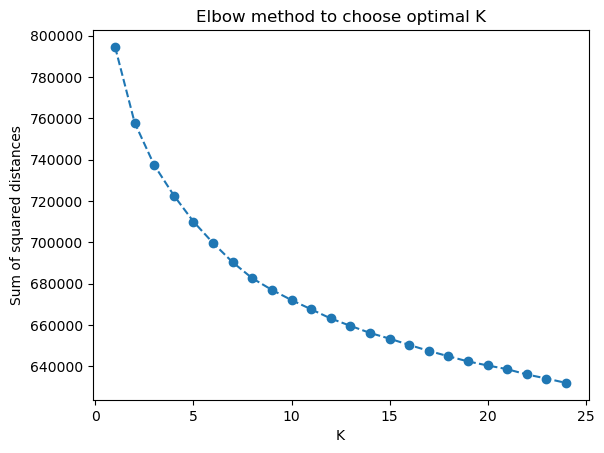

In [144]:
# Plot the elbow curve

plt.plot(K, wcss, marker='o', linestyle='--') # can load previous results of wcss
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method to choose optimal K')
plt.show()

The Elbow method advise us to pick a number of clusters which is not too big but still encompasses enough dissimilarity between them. With this method, we should choose a number that sits in the angle of the curve. Here, the curve does not have a very sharp angle, I would take a value between 5 and 10 clusters. 

In [286]:
# K-Means with 5 clusters

km_5 = KMeans(n_clusters=5)
km_5 = km_5.fit(counts) # Computation: 1'40

In [289]:
# Clusters observation (K=5)

# Find centroids
order_centroids_5 = km_5.cluster_centers_.argsort()[:, ::-1]

print("Top terms per cluster:")
for i in range(5):
    top_15_words = [terms[ind] for ind in order_centroids_5[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_15_words)))

Top terms per cluster:
Cluster 0: sugar flour butter salt eggs purpose baking milk large vanilla powder cream extract water unsalted
Cluster 1: salt cheese pepper oil onions garlic chicken water sauce fresh cream butter ground green sugar
Cluster 2: sauce oil soy garlic pepper sugar sesame rice onions fresh ginger chicken salt green water
Cluster 3: pepper ground salt garlic oil black onions powder chicken cumin red fresh green tomatoes onion
Cluster 4: fresh oil pepper olive salt garlic cheese tomatoes cloves black ground red chopped parsley juice


There is the again the cake recipe cluster, and what I would attribute in order: a recipe for creamy chicken sauce, Asian cuisine ingredients, Mexican or Indian (southern) style meal, and Italian/Mediterranean ingredients

In [290]:
# K-Means with 10 clusters

km_10 = KMeans(n_clusters=10)
km_10 = km_10.fit(counts) # Computation: 3min

In [291]:
# Clusters observation (K=10)

# Find centroids
order_centroids_10 = km_10.cluster_centers_.argsort()[:, ::-1]

print("Top terms per cluster:")
for i in range(10):
    top_15_words = [terms[ind] for ind in order_centroids_10[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_15_words)))

Top terms per cluster:
Cluster 0: pepper bell red garlic salt green oil onions ground black chicken fresh tomatoes olive sauce
Cluster 1: pepper salt black ground garlic oil onions chicken butter flour water fresh onion white sauce
Cluster 2: powder salt garlic oil ground cumin chili onions cilantro tomatoes green leaves ginger pepper coriander
Cluster 3: sugar flour butter salt eggs purpose baking large vanilla milk powder extract cream unsalted water
Cluster 4: sugar salt water oil sauce fresh butter milk garlic juice onions cream chicken flour white
Cluster 5: ground pepper salt garlic oil cumin fresh black cloves chicken onions olive chopped powder ginger
Cluster 6: oil olive pepper salt garlic fresh tomatoes cheese cloves extra virgin black ground red wine
Cluster 7: fresh juice chopped oil salt pepper garlic lime cilantro lemon olive ground cloves onion chicken
Cluster 8: sauce oil soy garlic sesame sugar pepper rice onions ginger chicken salt fresh water green
Cluster 9: cheese 

With 10 clusters, we can see similar structure to the 5 ones. With some ingredients for bakery (cluster 3), Asian cuisine (cluster 8) Italian/Mediterranean (clusters 0,6,9) Southern/Mexican/Indian/Sunny&Spicy cuisine (clusters 2,5,7) and casual white sauce/creamy chicken dish (clusters 1,2,4). These clusters seem to be follow the distribution of cuisine regions in the dataset, with a lot of Italian recipes (either Mediterranean ingredients like tomato, olive oil, garlic, or with the American fascination of chicken Alfredo with a creamy/buttery chicken sauce), followed by recipes from countries that are sunny and hot, where they have a lot of fresh ingredients and spices (cilantro, lime, lemon, tomatoes, garlic with various spices: coriander, cumin, chili, pepper, cloves..). <br>
We can clearly see how these recipes come from an American community from the initial cuisine distribution and clusters that emerges from the ingredients lists. These clusters are still fairly general, having at least the 25 clusters allowed for more nuances between the big categories (difference between Mexican and Indian or Japanese and Chinese for example)

------------------

In [17]:
# 2nd model
# Computation: 25 clusters(~5min30)

number_of_clusters=25
km2 = KMeans(n_clusters = number_of_clusters)
km2.fit(counts2)

KMeans(n_clusters=25)

In [18]:
# Clusters observation

# Find centroids
order_centroids2 = km2.cluster_centers_.argsort()[:, ::-1]

# List of features
terms2 = count_vect2.get_feature_names_out()

for i in range(number_of_clusters):
    top_15_words = [terms2[ind] for ind in order_centroids2[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_15_words)))

Cluster 0: baking purpose soda buttermilk large unsalted cream vanilla corn cinnamon extract brown granulated yellow shortening
Cluster 1: corn tortillas beans starch cumin chili frozen cream yellow kernels chilies broth purpose jack chile
Cluster 2: parsley leaf flat wine lemon extra virgin dry bay thyme large broth carrots leaves celery
Cluster 3: vinegar wine cider leaves balsamic mustard soy brown kosher bay pork cucumber purple basil lemon
Cluster 4: lime chilies cumin jalapeno avocado corn purple tortillas chili chile leaves beans wedges kosher oregano
Cluster 5: large egg yolks whites cream purpose unsalted vanilla lemon extract chocolate spray heavy cooking fat
Cluster 6: soy corn starch ginger sesame vinegar wine boneless scallions sodium broth skinless pork chili breasts
Cluster 7: boneless skinless breasts breast halves broth cumin ginger cream lime seasoning bell lemon dried chili
Cluster 8: sesame seeds soy toasted ginger vinegar scallions carrots chili brown flakes honey 

Could remove bit more stopwords (fat, sodium, free, low, large, dried, meal...) but at the same time, some words are more common in specific region. For example, maybe most regions say salt but american could be used to say sodium instead, or 'free' as in free-range chicken/eggs may be something more present in western culture so it still carries some meaning and distinction.

--------------

### PCA

Principal Component Analysis is a popular technique to derive a set of low dimensional features from a much larger set while still preserving as much variance as possible. It is often used to do variable selection or to visualize high-dimensional data.
Here we will use it for the latter purpose. We start with 3010 features which represent the total number of ingredients in our recipes and reduce it down to the 2 principal components which we'll be able to graphically visualize.

####  Overview of cuisines

Here we apply PCA on our whole dataset, keeping only the 2 principal components

In [186]:
# Model
pca = PCA(n_components=2)

# Fit & Transform
counts_array = counts.toarray()
pca.fit(counts_array)
counts_pca = pca.transform(counts_array)

In [20]:
print("Original shape: {}".format(str(counts.shape)))
print("Reduced shape: {}".format(str(counts_pca.shape)))

Original shape: (39774, 2970)
Reduced shape: (39774, 2)


We can then plot all the recipes in function of their principal components

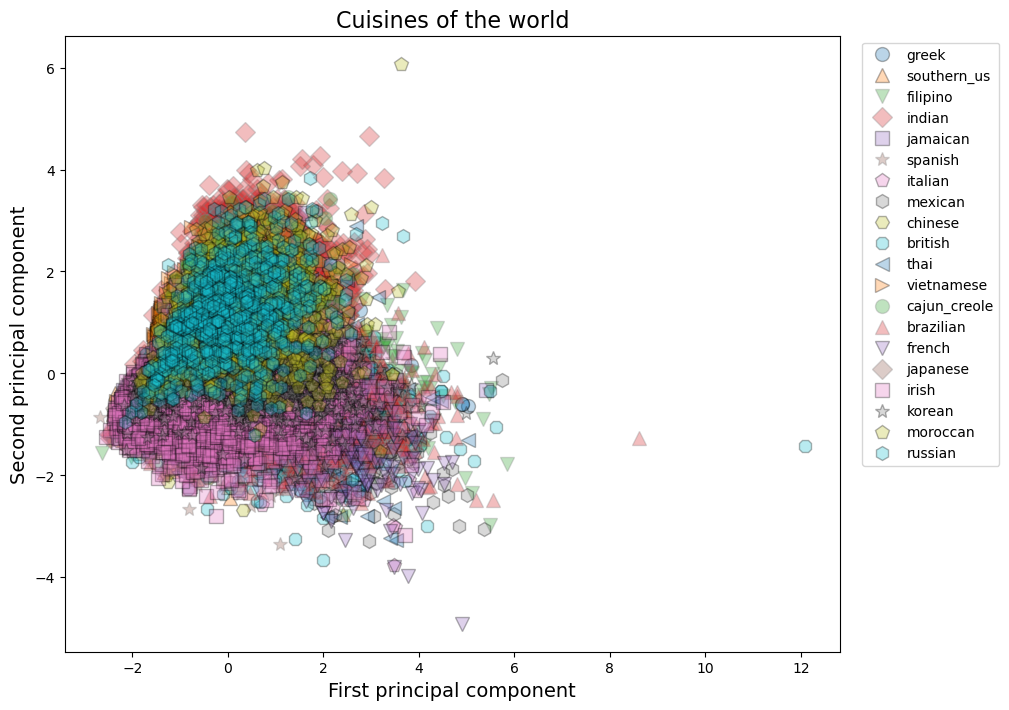

In [21]:
# Graph
plt.figure(figsize = (10,8))
mglearn.discrete_scatter(counts_pca[:,0], 
                         counts_pca[:,1], 
                         df.cuisine, 
                         alpha=.3)

plt.legend(['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican',
            'chinese', 'british', 'thai', 'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
            'irish', 'korean', 'moroccan', 'russian'],bbox_to_anchor=(1.02, 1), loc=2)
plt.title("Cuisines of the world",fontsize=16)
plt.xlabel("First principal component",fontsize=14)
plt.ylabel("Second principal component",fontsize=14);

#plt.savefig('./img/recipes_pca.png',dpi=300,bbox_inches='tight')

The recipes are globally well packed up, although we can see some distinct regions (pink squares at the bottom, turquoise hexagons at the top). One great thing is that, from the few clusters we can see, they seem to not have too large intra-cluster variance, we can see clear grouping of them. We could try to reduce the number of cuisines to see clearer separations.

#### Focus on few cuisines

Here I arbitrarily chose to  focus on Japanese, Greek, Russian & Cajun/Creole cuisines.

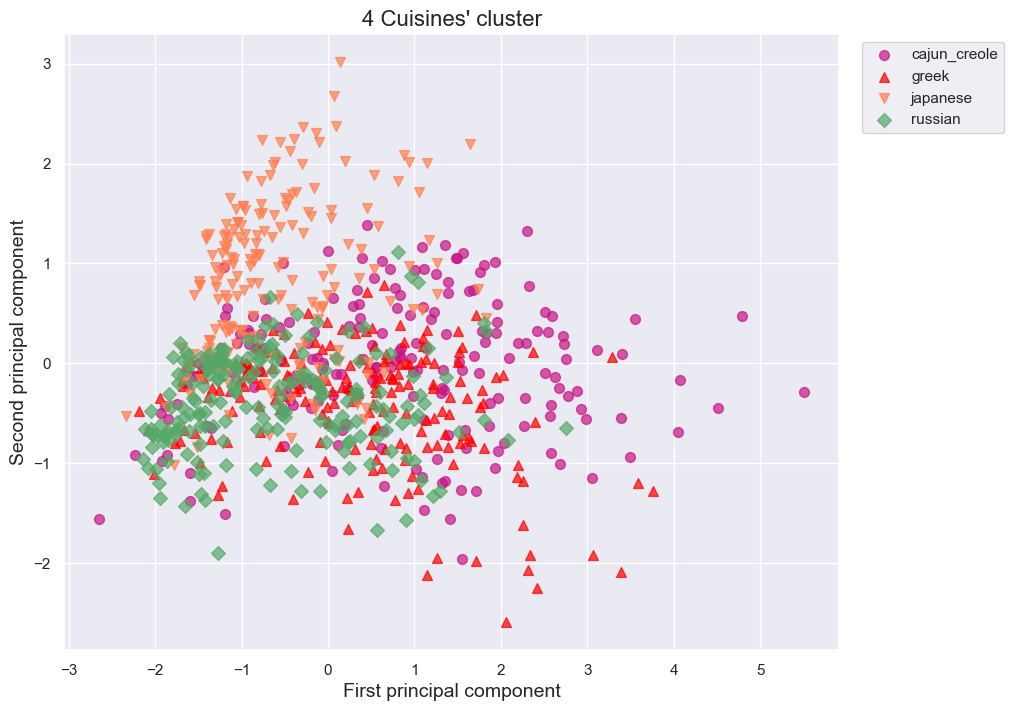

In [251]:
# Selection
selected_cuisines = ['cajun_creole','japanese','greek','russian']

# Graph
fig, ax = plt.subplots(figsize = (10,8))
for j, g in enumerate(np.unique(selected_cuisines)):
    ix = np.where(df['cuisine'] == g)[0]
    ax.scatter(counts_pca[ix[:200], 0], 
               counts_pca[ix[:200], 1], 
               c=colors[g], 
               label=g, 
               alpha=.7, 
               marker=markers[j], 
               s=50)

ax.legend(bbox_to_anchor=(1.02, 1), loc=2)
ax.set_xlabel("First principal component",fontsize=14)
ax.set_ylabel("Second principal component",fontsize=14)
ax.set_title("4 Cuisines' cluster",fontsize=16);

#fig.savefig('./img/recipes_4_selected_pca.png',dpi=300,bbox_inches='tight')

From this second graph, we can observe more distinction between the cuisines. There are still some heavy overlapping in the middle-left part of the graph, but they all seem to diverge in a different direction. Japanese cuisine tend to have a higher degree of the 2nd principal component, while Greek and Cajun/Creole have on average a higher amount of the 1st principal component. 
<br>
To reduce the noise in these graphs and get another view of the resulting PCA model, we can focus on cuisine centroids, the average points of all recipes.

#### Centroids

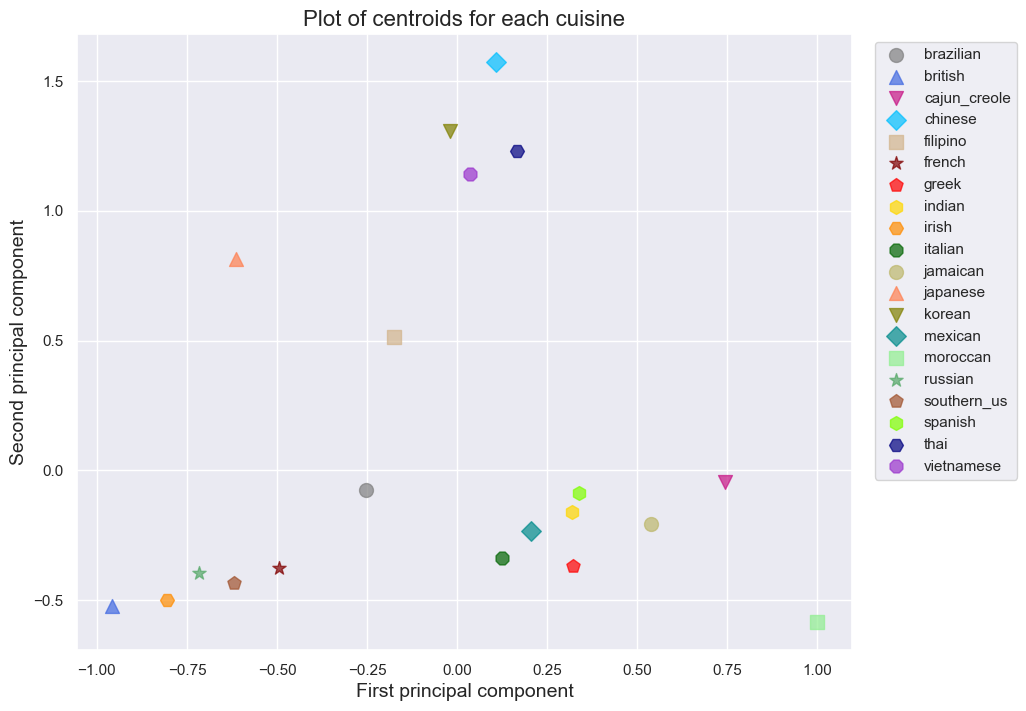

In [250]:
# Graph
fig, ax = plt.subplots(figsize = (10,8))
for j, g in enumerate(np.unique(keys)):
    ix = np.where(df['cuisine'] == g)[0]
    ax.scatter(np.mean(counts_pca[ix, 0]), 
               np.mean(counts_pca[ix, 1]), 
               c=colors[g], 
               label=g, 
               alpha=.7, 
               marker=markers[j], 
               s=100)
    
ax.legend(bbox_to_anchor=(1.02, 1), loc=2)
ax.set_xlabel("First principal component",fontsize=14)
ax.set_ylabel("Second principal component",fontsize=14)
ax.set_title("Plot of centroids for each cuisine",fontsize=16);

#fig.savefig('./img/recipes_centroids_pca.png',dpi=300,bbox_inches='tight')

This centroid plot is much easier to read. We can see some clusters of cuisines emerging. For example, the 4 points at the very top are Chinese, Korean, Thai & Vietnamese cuisines, which are regionally very close. Japanese and Filipino cuisines are not too far from the first 4, but with each their own offset on the graph. On the bottom left we can see British, Irish, Russian, Southern_us and French cuisine making another cluster of European meals. On the bottom middle right part, another cluster is formed with Italian, Mexican, Indian, Spanish, Greek, Jamaican, Cajun/Creole, and a bit further, Moroccan cuisines. These are a mix of countries with cuisine full of spices and Mediterranean countries. A common ingredient shared by these countries could be the tomato. <br>
Although reducing such high dimensional data to only 2 dimensions may seem extreme and lack depth in the specificity between cuisines, we can already see very logical patterns that underlines a working methodology. 

#### Ingredients association 

Another way to look at our PCA results is to look at the way ingredients were classified among the 2 principal components. We can get these 2 values for each ingredient, plot them, then check what are the similarities between them, and the logic the model has been trying to extract.

In [26]:
# Ingredients principal components table
words = count_vect.get_feature_names_out()
pca_df = pd.DataFrame(pca.components_,
                      columns=words,
                      index=['first', 'second'])
pca_df

,00,10,100,14,15,25,33,40,43,95,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
first,-0.000020,-0.000011,-0.000029,0.000020,-0.00001,0.000015,0.000041,0.000035,-2.806522e-05,0.000087,...,0.000047,-0.000016,-0.000008,-0.000005,-0.001009,-0.000055,-0.000032,0.000320,0.012891,-0.000048
second,-0.000003,-0.000036,-0.000001,-0.000144,-0.00007,-0.000032,-0.000035,-0.000118,1.741740e-07,-0.000089,...,-0.000034,0.000006,0.000009,0.000026,-0.006452,-0.000226,-0.000018,-0.000639,-0.000763,-0.000047


Since there are a lot of ingredients in our corpus, we won't be able to plot them all. To get ingredients with various polarity, I will just extract several elements with the highest and lowest values for each of the 2 principal components.

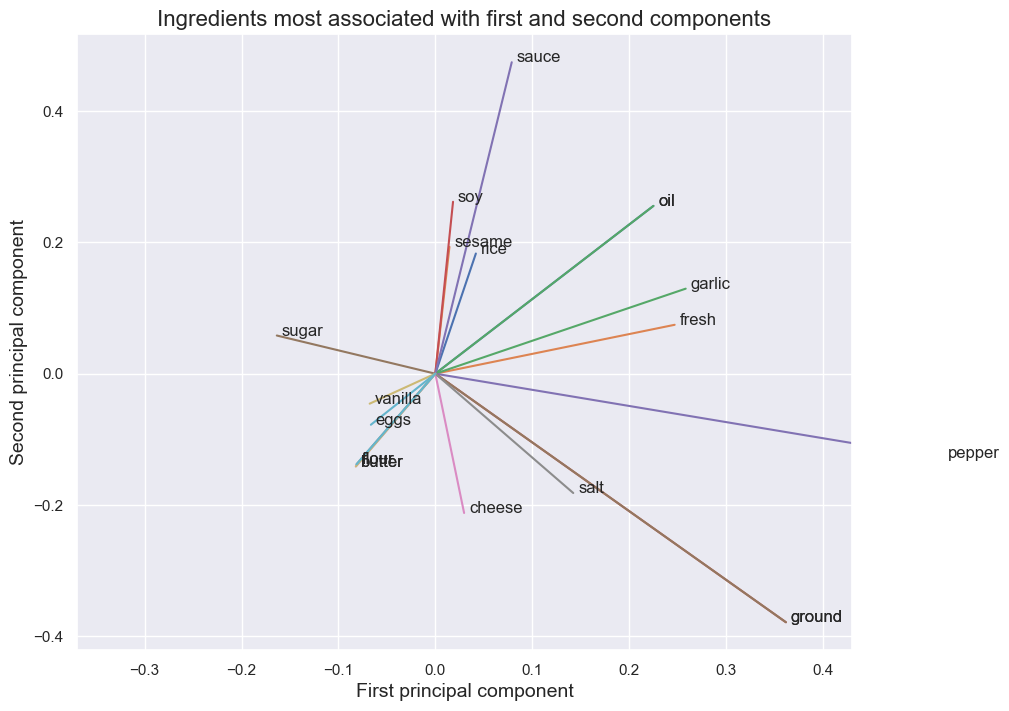

In [252]:
# Ingredients selection
select_ingredients = np.empty([20,], dtype=object)
select_ingredients[:5] = pca_df.iloc[:, np.argsort(pca_df.loc['first'])[-5:]].columns
select_ingredients[5:10] = pca_df.iloc[:, np.argsort(pca_df.loc['first'])[:5]].columns
select_ingredients[10:15] = pca_df.iloc[:, np.argsort(pca_df.loc['second'])[-5:]].columns
select_ingredients[15:] = pca_df.iloc[:, np.argsort(pca_df.loc['second'])[:5]].columns

# Graph
fig, ax = plt.subplots(figsize = (10,8))
for i in select_ingredients:
    x = [0, pca_df.loc['first', i]]
    y = [0, pca_df.loc['second', i]]
    ax.plot(x, y, label=i)
    ax.text(x[1]+.005, y[1], i, fontsize=12)
    
ax.set_xlabel("First principal component", fontsize=14)
ax.set_ylabel("Second principal component", fontsize=14)
ax.set_title("Ingredients most associated with first and second components", fontsize=16)
ax.set_xlim([-.37,.43]);

#fig.savefig('./img/ingredients_pca.png',dpi=300)

This graph shows the vectorized position of the ingredients among the 2 principal components of the model. Again, we can see some groups of ingredients that share really similar attributes. Soy, sesame, rice, sauce, oil, garlic, fresh on the top right corner are all ingredients commonly found in Asian cuisine. While on the bottom left side: flour, butter, eggs, vanilla & sugar are very common pastry ingredients. <br>
It is interesting to see how just 2 variables can capture so much information about a very large number of various ingredients.

Our simple 2 dimensional PCA model has been working great. However, we don't know how much it really captured overall nuances. We can check this with the explained variance ratio which is a ratio of the variance a model with K components can keep compared to one with all of its components.

#### Cumulative explained variance

Here I plot the cumulative explained variance for all k combination of principal components.

[7.07604993e-02 4.00388345e-02 3.49737761e-02 ... 4.18149272e-36
 3.45463899e-36 3.56824283e-37]


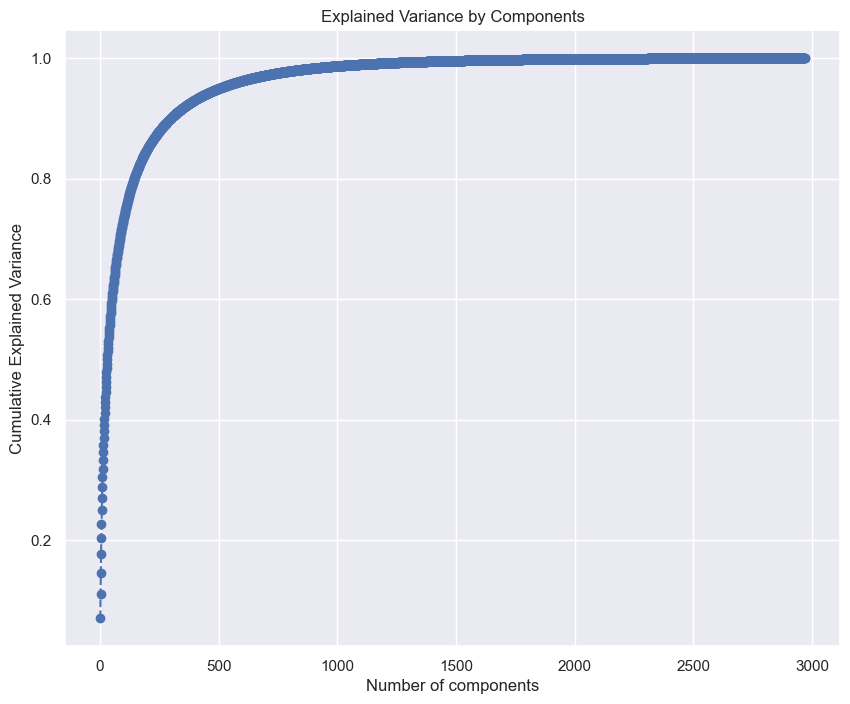

In [249]:
# 1min to fit
# Model
pca2 = PCA()

# Fit
pca2.fit(counts_array)

# Check explained variance ratio
print(pca2.explained_variance_ratio_)

# Plot the Cumulative Explained Variance
plt.figure(figsize=(10,8))
plt.plot(range(1,2971), pca2.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance');

This curve represent the amount of variance a PCA with k components would contain. We can see a very sharp curve, increasing very fast on the first few several hundreds of components, before curving horizontally. This means that a model that would have 500 principal components would contain almost 95% of the variance coming from all ingredients. Unfortunately, we can see that a model with just 2 principal components does not carry a majority of the total variance.

In [281]:
print('Variance ratio of the first 2 principal components: {}%'.format(round(sum(pca2.explained_variance_ratio_[0:2])*100,2)))

Variance ratio of the first 2 principal components: 11.08%


Our model with 2 principal components captures only 11% of total variance, yet it still manages to understand a lot of similarity between ingredients and cuisines. <br>
Here are the number of components that would be needed, with our current dataset, to carry more overall variance:

In [284]:
# Choice of number of principle components
print('Number of Principle Components to keep 50% of data variance: ', np.where(pca2.explained_variance_ratio_.cumsum()>0.5)[0][0])
print('Number of Principle Components to keep 80% of data variance: ', np.where(pca2.explained_variance_ratio_.cumsum()>0.8)[0][0])
print('Number of Principle Components to keep 90% of data variance: ', np.where(pca2.explained_variance_ratio_.cumsum()>0.9)[0][0])
print('Number of Principle Components to keep 95% of data variance: ', np.where(pca2.explained_variance_ratio_.cumsum()>0.95)[0][0])
print('Number of Principle Components to keep 99% of data variance: ', np.where(pca2.explained_variance_ratio_.cumsum()>0.99)[0][0])
print('Initial number of features (ingredients): ', len(feature_names))

Number of Principle Components to keep 50% of data variance:  29
Number of Principle Components to keep 80% of data variance:  143
Number of Principle Components to keep 90% of data variance:  297
Number of Principle Components to keep 95% of data variance:  502
Number of Principle Components to keep 99% of data variance:  1112
Initial number of features (ingredients):  3010


### LDA

LDA is used to discover latent (hidden) topics within data thanks to Dirichlet distributions. There are 2 Dirichlet distributions used in LDA, one over the topics (here, ideally the cuisine) in each document and another over the words (ingredients) in each topic. Contrary  to PCA and other algorithms that use distance measures to determine similarity, LDA is based on the frequency counts of words within topics.

In [28]:
# Model
# Computation: 25_components(5'30)

lda = LatentDirichletAllocation(n_components=25, 
                                learning_method="batch", 
                                max_iter=25, 
                                random_state=0)

# Fit
recipe_topics = lda.fit_transform(counts)
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (25, 2970)


In [29]:
sorting = np.argsort(lda.components_, axis=1)[:,::-1]
feature_names_2 = np.array(count_vect.get_feature_names_out())

In [33]:
mglearn.tools.print_topics(topics=range(25),
                           feature_names=feature_names_2,
                           sorting=sorting,
                           topics_per_chunk=9,
                           n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       
--------      --------      --------      --------      --------      --------      --------      --------      --------      
pork          pepper        dried         ground        cheese        sesame        cheese        sugar         chicken       
pepper        red           oregano       pepper        cream         oil           fresh         egg           boneless      
ground        vinegar       tomato        salt          sour          sauce         parmesan      cream         skinless      
salt          oil           garlic        cumin         shredded      soy           oil           vanilla       breasts       
garlic        olive         pepper        garlic        tortillas     rice          olive         milk          breast        
sauce         salt          tomatoes      fresh         cheddar       seeds         pepper        extract      

Again, we can see similar groups of ingredients to previous results. There are regional clusters (0: Eastern Asia, 2: Mediterranean, 4: Mexican, 5: Japanese, 14: French...). Although it looks like this algorithm got a different understanding, with more categories of food. There are groups of ingredients by category (1: Condiments, 3: Spices, 17: Citrus/Fresh fruits and herbs, 16,19: healthy ingredients...) and common recipes (7,20: Cakes, 9: Breads). It seems like LDA captured better the role of some ingredients rather than their relative occurrence in recipes like previously. It may be due to the fact that LDA and K-Means use spatial distance as a measure of similarity whereas LDA use term occurrence and so it found ingredients that appear in similar context rather than words that appear together often.

## Conclusion

Thanks to the various techniques employed here, I managed to extract simple similarity measures between various cuisines and ingredients association. We can see how the models captured similarity between geographically close places (Thai, Chinese, Korean, Vietnam on one side, Spanish, Mexican, Indian on the other..) and ingredient types (condiments, citrus, baking staples). 
The dataset I used is not really optimal for this task as it feels very influenced by American cooking and habits. I see several big biases that should be accounted for in a further analysis, to extract clearer insights:
- Get a more equal distribution of recipes
- Have the recipes written by locals or taken from locals/chefs with more precise ingredients choices (From experience and looking at the data, I know people often cut corners when doing international dishes (using lemon instead of limes, curry powder instead of specific set of spices, white wine instead of mirin etc.) which is fine in practice, but which creates biases for this kind of task)
- keep n-gram of words as some ingredients share same component (ground black pepper VS bell pepper)

## Additional material

### PCA and K-Means

It is possible to combine PCA and K-Means algorithm for more efficient modelling. Indeed, we can reduce noisy information by preselecting the principal components through PCA before applying a K-Means algorithm for clear clustering.

In [86]:
# Models
pca80 = PCA(n_components=143)
pca90 = PCA(n_components=297)
pca95 = PCA(n_components=502)

# Fit
pca80.fit(counts_array)

# Keep calculated resulting components scores for the elements in our dataset
scores_pca80 = pca80.transform(counts_array)

In [91]:
# Applying K-means on 
# Computation time: K=range(1,5):7s, K=range(1,10):23s, K=range(1,30):3min25

wcss_pca80 = [] # Within-cluster sum of squares
K = range(1,30)
for k in K:
    km_pca80 = KMeans(n_clusters=k)
    km_pca80 = km_pca80.fit(scores_pca80)
    wcss_pca80.append(km_pca80.inertia_)

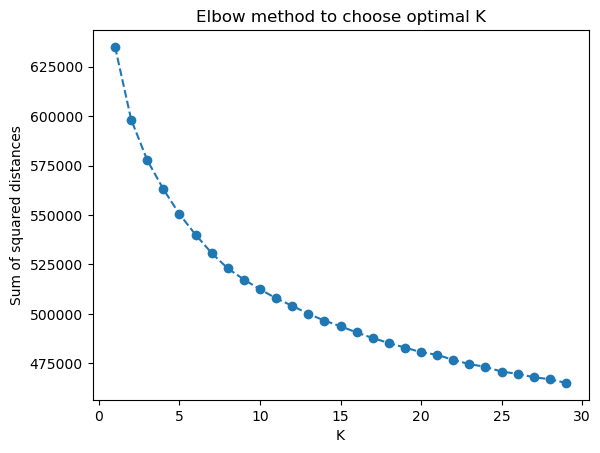

In [92]:
# Plot the elbow curve

plt.plot(K, wcss_pca80, marker='o', linestyle='--')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method to choose optimal K')
plt.show()

From this graph, we can determine the number of clusters we want to keep. Using the Elbow method, I decide to keep 10 clusters.
We can now implement the K-means clustering algorithm with the chosen number of clusters

In [93]:
# K-means model
kmeans_pca80 = KMeans(n_clusters = 10,
                      init = 'k-means++',
                      random_state = 0)
# Model fit with principal components scores
kmeans_pca80.fit(scores_pca80)

KMeans(n_clusters=10, random_state=0)

In [98]:
# Results

df_pca80 = df.copy()
df_pca80['Cluster'] = kmeans_pca80.labels_
df_pca80.head(3)

,id,cuisine,ingredients,ingredients_string,Cluster
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...,9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...,1
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...,6


In [111]:
pd.DataFrame(scores_pca80)[:2]

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,-0.066841,-0.510578,0.430887,1.154517,0.620896,-0.232621,-0.331172,-0.622670,-0.157093,-0.674858,...,-0.053482,0.307238,-0.148087,-0.294309,0.109994,-0.238635,0.128690,-0.162350,0.106591,-0.162417
1,1.199452,-1.316914,-1.224489,0.069642,-0.309043,-0.334106,-0.108580,-0.241645,-0.232802,0.287942,...,0.143459,0.155415,-0.012209,-0.015597,0.042306,0.165428,0.035422,0.100817,-0.018154,-0.069029


In [115]:
df_pcaXX = pd.concat([df_pca80, pd.DataFrame(scores_pca80)], axis=1)
df_pcaXX.head(3)

,id,cuisine,ingredients,ingredients_string,Cluster,0,1,2,3,4,...,133,134,135,136,137,138,139,140,141,142
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...,9,-0.066841,-0.510578,0.430887,1.154517,0.620896,...,-0.053482,0.307238,-0.148087,-0.294309,0.109994,-0.238635,0.128690,-0.162350,0.106591,-0.162417
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...,1,1.199452,-1.316914,-1.224489,0.069642,-0.309043,...,0.143459,0.155415,-0.012209,-0.015597,0.042306,0.165428,0.035422,0.100817,-0.018154,-0.069029
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...,6,0.312870,0.769161,-0.839508,0.648466,0.097039,...,-0.016164,-0.055193,-0.173232,0.008825,0.034810,0.147212,0.132248,0.128975,-0.146260,-0.044708


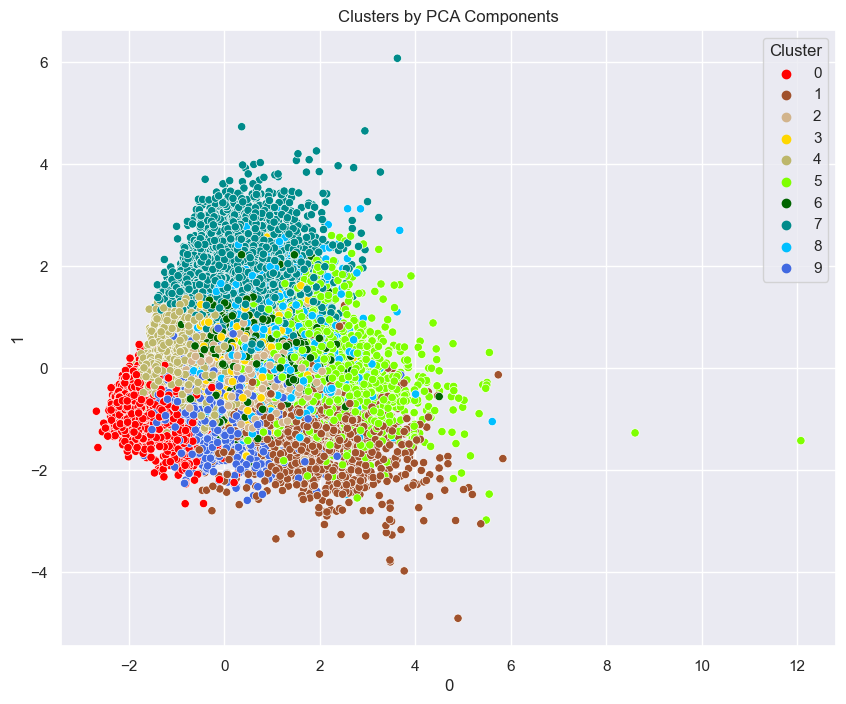

In [198]:
# Plot data by PCA components
x_axis = df_pcaXX[0]
y_axis = df_pcaXX[1]
plt.figure(figsize=(10,8))
sns.scatterplot(x = x_axis, 
                y = y_axis, 
                hue=df_pcaXX['Cluster'], 
                palette=color_vals[0:10])
plt.title('Clusters by PCA Components')
plt.show()

In [223]:
pca80.components_.shape

(143, 2970)

In [226]:
order_centroids_pca80[0]

array([  5,   6,   7,  11,  12,  10,   9,  44,  55,  61,  48,  23,  43,
        59,  50,  25,  16,  64,  52,  22,  60,  62,  34,  66,  31,  67,
        30,  33,  95,  19,  35,  63,  72, 116,  28,  56, 126,  38,  46,
       142, 115,  70,  90, 110, 100, 119,  15, 140, 112, 134,  92,  86,
        77,  97, 137,  82,  76, 138, 132, 131,  83,  21,  89,  29, 129,
        88,  74, 125, 128,  57,  49, 113, 106, 135,  68, 107, 127, 114,
        94,  96,  85, 109,  73, 139, 108, 133, 130,  98, 103,  99, 120,
       104,  24, 101, 102, 111, 121, 122, 141, 136,  75, 105,  78,  87,
        91, 124,  93,  69, 118, 117,  71,  84,  79,  40,  80,  39,  26,
        81,  47, 123,  65,  58,  41,  54,  36,  27,  32,  45,  53,  37,
        20,  42,  14,  17,  51,  18,  13,   8,   3,   2,   1,   4,   0],
      dtype=int64)

In [238]:
pca80.components_[5].argmax()

1030

In [ ]:
# Focus on Principal Component number 5
print('The 5th principal component is a vectorial combination of initial features: ', pca.components_)
print()

# Positions of the elements with largest score
PC5_top10_index = np.argsort(-pca80.components_[5])[:10]
print('Indices of the 10 elements with largest score: ', PC5_top10_index)
print('Scores at the 10 elements: ', [pca80.components_[5][x] for x in PC5_top10_index])
print('List of the specified elements: ', terms[PC5_top10_index])

In [190]:
pca.components_

array([[-1.94096585e-05, -9.76748259e-06, -2.89891497e-05, ...,
         3.19060495e-04,  1.29274158e-02, -4.77853112e-05],
       [-1.04132364e-06, -2.51403588e-05,  5.99704582e-07, ...,
        -5.74619229e-04, -1.24459936e-04, -4.39698334e-05]])

### Interpretation

It is hard to extract clear interpretation from principal components but we can attempt it nonetheless. <br>
Since there were initially 3010 ingredients, from which we derived 143 principal components, we have created 143 combinations of 3010 variables.
Each cluster are a distinct combination of these 143 vectors.
It is possible to observe the vectors that represent best a cluster to get an idea of what it represents. Then observe what each of these vectors try to represent from the set of ingredients. <br>
Let's take a look at an example:

In [337]:
# Focus on Principal Component number 5
print('The 5th principal component is a vectorial combination of initial features: ', pca80.components_[5])
print()

# Positions of the elements with largest score
PC5_top10_index = np.argsort(-pca80.components_[5])[:10]
print('Indices of the 10 elements with largest score: ', PC5_top10_index)
print('Scores at the 10 elements: ', [pca80.components_[5][x] for x in PC5_top10_index])
print('List of the specified elements: ', terms[PC5_top10_index])

The 5th principal component is a vectorial combination of initial features:  [-5.14241991e-05 -4.67684294e-06  5.24665521e-07 ... -3.10662492e-05
 -2.53138824e-03  5.09900614e-05]

Indices of the 10 elements with largest score:  [1030 1970 2618  529  369  570 1001  700 2346  515]
Scores at the 10 elements:  [0.36335562672424143, 0.23305849121649114, 0.21503822237530185, 0.2104099335392782, 0.19537071914665008, 0.1845772773593622, 0.18228863936232156, 0.1742451416025657, 0.1699852299317262, 0.1508701887631323]
List of the specified elements:  ['fresh' 'pepper' 'sugar' 'chicken' 'butter' 'chopped' 'flour' 'cream'
 'sauce' 'cheese']


In [344]:
pd.DataFrame([pca80.components_[5][x] for x in PC5_top10_index],terms[PC5_top10_index], columns=['Score'])

,score
fresh,0.363356
pepper,0.233058
sugar,0.215038
chicken,0.210410
butter,0.195371
chopped,0.184577
flour,0.182289
cream,0.174245
sauce,0.169985
cheese,0.150870


In [341]:
np.argsort(-pca80.components_[5])[:10]

array([1030, 1970, 2618,  529,  369,  570, 1001,  700, 2346,  515],
      dtype=int64)

In [381]:
pd.set_option('display.max_rows', 500)
number_of_PC = 10
number_of_components=100

def PC_content(pca_model = pca80, number_of_PC=10, number_of_components=10):
    df_total = pd.DataFrame()
    for PC in range(number_of_PC):
        ind = np.argsort(-pca_model.components_[PC])[:number_of_components]
        df_ = pd.DataFrame({'Ingredient':terms[ind], 'Score':[pca_model.components_[PC][x] for x in ind]})
        df_ = add_top_column(df_, "PC {}".format(PC))
        df_total = pd.concat([df_total,df_],axis=1)
    return df_total

PC_res = PC_content(pca80, number_of_PC, number_of_components)
PC_res

PC 0                      PC 1                  PC 2            \
   Ingredient     Score      Ingredient     Score  Ingredient     Score   
0      pepper  0.523607           sauce  0.474086       fresh  0.558289   
1      ground  0.361922             soy  0.261672       olive  0.221516   
2      garlic  0.258455             oil  0.255458      cheese  0.194892   
3       fresh  0.247066          sesame  0.193111       juice  0.144890   
4         oil  0.225165            rice  0.182921     chopped  0.133097   
5       black  0.200506          ginger  0.135998       lemon  0.114092   
6         red  0.173708          garlic  0.129364    tomatoes  0.099469   
7       olive  0.154176          onions  0.121855     parsley  0.094211   
8        salt  0.142398         chicken  0.114661       basil  0.090868   
9      onions  0.137449           green  0.107114      virgin  0.085163   
10    chicken  0.136259         vinegar  0.096605       extra  0.084255   
11       bell  0.124041           fresh  0.074397    parmesan  0.080849   
12   tomatoes  0.120329            fish  0.072593      cloves  0.079385   
13     cloves  0.116212            lime  0.067689      grated  0.065107   
14    chopped  0.115483       vegetable  0.065785        lime  0.058621   
15      green  0.114732          starch  0.064323    cilantro  0.048782   
16      onion  0.106438           water  0.060938         oil  0.048245   
17      cumin  0.091953           sugar  0.058103      leaves  0.044164   
18   cilantro  0.079403             red  0.056991  mozzarella  0.036951   
19      sauce  0.078895       scallions  0.056617        wine  0.035994   
20      dried  0.077851           chili  0.055695       onion  0.035421   
21    parsley  0.063163           seeds  0.051120        mint  0.032104   
22      broth  0.062468         carrots  0.049240      purple  0.030860   
23     leaves  0.060077         noodles  0.046058         dry  0.030841   
24    oregano  0.054819          sodium  0.043745     oregano  0.025753   
25     ginger  0.053660            corn  0.040552    rosemary  0.025563   
26      juice  0.051967        boneless  0.040076       bread  0.025144   
27      chili  0.047257        cilantro  0.038926      olives  0.024301   
28    cayenne  0.047150         chinese  0.038110       pasta  0.024180   
29      thyme  0.046955           paste  0.037757        plum  0.022989   
30       wine  0.045328            wine  0.037643        flat  0.022926   
31       rice  0.041858           brown  0.037402     italian  0.021611   
32     tomato  0.041728          peanut  0.036325        leaf  0.021582   
33    vinegar  0.040919         toasted  0.035690     spinach  0.020697   
34      basil  0.040702            pork  0.034992        feta  0.020547   
35     celery  0.039507         breasts  0.034476     ricotta  0.019006   
36      diced  0.039377          shrimp  0.034146       thyme  0.018897   
37    paprika  0.039151            dark  0.033926       spray  0.017090   
38      extra  0.038843         peanuts  0.033119    shallots  0.016854   
39       lime  0.038335        skinless  0.032934      capers  0.015953   
40    crushed  0.038321          oyster  0.031194    cucumber  0.014118   
41     virgin  0.037827         cabbage  0.029829   mushrooms  0.014005   
42  coriander  0.036516          leaves  0.029726    kalamata  0.013870   
43     powder  0.036082            thai  0.029347        zest  0.013218   
44     kosher  0.035608          hoisin  0.029272    balsamic  0.013102   
45   boneless  0.035311           white  0.027111      garlic  0.012954   
46        bay  0.035132          minced  0.025879      chives  0.012882   
47      white  0.035089       mushrooms  0.025526     avocado  0.012648   
48  vegetable  0.033995          cloves  0.024557         fat  0.012510   
49     sodium  0.033304     beansprouts  0.024469    crumbles  0.012425   
50     yellow  0.033035        shiitake  0.024460      finely  0.011927   
51      beans  0.031218           

In [ ]:
rows = [{'species': 'Tetraodon lineatus', 'age': 1, 'length': 8.0, 'weight': 9.0},
        {'species': 'Tetraodon fahaka', 'age': 1, 'length': 8.0, 'weight': 9.0}]
df = df.append(rows, ignore_index=True)

In [423]:
def PC_content(pca_model = pca80, number_of_PC=10, number_of_components=10):
    df_total = pd.DataFrame()
    for PC in range(number_of_PC):
        ind = np.argsort(-pca_model.components_[PC])[:number_of_components]
        ind_bottom = np.argsort(-pca80.components_[PC])[-number_of_components:]
        df_ = pd.DataFrame({'Ingredient':terms[ind], 'Score':[pca_model.components_[PC][x] for x in ind]})
        df_ = pd.concat([df_,pd.DataFrame([{'Ingredient':'----------','Score':'---------'}])])
        df_bottom = pd.DataFrame({'Ingredient':terms[ind_bottom], 'Score':[pca_model.components_[PC][x] for x in ind_bottom]})
        df_ = pd.concat([df_,df_bottom])
        df_ = add_top_column(df_, "PC {}".format(PC))
        df_total = pd.concat([df_total,df_],axis=1)
    return df_total
PC_content()

PC 0                    PC 1                    PC 2              \
   Ingredient       Score  Ingredient       Score  Ingredient       Score   
0      pepper    0.523607       sauce    0.474086       fresh    0.558289   
1      ground    0.361922         soy    0.261672       olive    0.221516   
2      garlic    0.258455         oil    0.255458      cheese    0.194892   
3       fresh    0.247066      sesame    0.193111       juice     0.14489   
4         oil    0.225165        rice    0.182921     chopped    0.133097   
5       black    0.200506      ginger    0.135998       lemon    0.114092   
6         red    0.173708      garlic    0.129364    tomatoes    0.099469   
7       olive    0.154176      onions    0.121855     parsley    0.094211   
8        salt    0.142398     chicken    0.114661       basil    0.090868   
9      onions    0.137449       green    0.107114      virgin    0.085163   
0  ----------  ----------  ----------  ----------  ----------  ----------   
0       cream   -0.048325      powder   -0.088161       green    -0.08229   
1     purpose   -0.049665     purpose   -0.098166        salt   -0.089083   
2     extract   -0.053961       cream   -0.099527      onions   -0.105974   
3        milk   -0.059031       black   -0.115411         soy   -0.115482   
4      baking   -0.059533      pepper   -0.128559       flour   -0.130339   
5        eggs   -0.066511       flour   -0.137922      powder   -0.195647   
6     vanilla   -0.067746      butter   -0.141176      pepper   -0.203849   
7       flour   -0.081321        salt   -0.181661       sugar    -0.20708   
8      butter   -0.082038      cheese   -0.212065       sauce   -0.213586   
9       sugar   -0.163628      ground   -0.378365      ground   -0.354903   

         PC 3                    PC 4                    PC 5              \
   Ingredient       Score  Ingredient       Score  Ingredient       Score   
0      cheese    0.359403      cheese    0.290647       fresh    0.363356   
1      pepper    0.318516      ground    0.280666      pepper    0.233058   
2        bell    0.131593     chicken     0.17387       sugar    0.215038   
3    parmesan    0.095975       cumin    0.152478     chicken     0.21041   
4         red    0.092441    cilantro    0.139846      butter    0.195371   
5       green    0.088739      onions    0.133142     chopped    0.184577   
6      onions    0.085838    shredded    0.126227       flour    0.182289   
7    shredded    0.079754       cream    0.111774       cream    0.174245   
8     chicken    0.079438       sauce    0.105296       sauce    0.169985   
9       dried    0.075665       green    0.102845      cheese     0.15087   
0  ----------  ----------  ----------  ----------  ----------  ----------   
0    cinnamon   -0.102169      butter   -0.135727       cumin   -0.048089   
1       cumin   -0.118491       large   -0.137763       seeds   -0.055478   
2        lime   -0.123837         red   -0.140862    tomatoes   -0.058044   
3       lemon   -0.126376     purpose   -0.156556      cloves   -0.063852   
4    cilantro   -0.129898       olive   -0.178225      garlic   -0.073379   
5      ginger   -0.158165       flour   -0.188857       extra   -0.104226   
6       juice   -0.191526       sugar   -0.237697      virgin   -0.105047   
7       sugar   -0.220829         oil   -0.238624      ground   -0.229245   
8       fresh   -0.424464        salt   -0.247133       olive   -0.248549   
9      ground   -0.437808      pepper   -0.304312         oil   -0.337388   

         PC 6                    PC 7                    PC 8              \
   Ingredient       Score  Ingredient       Score  Ingredient       Score   
0      cheese    0.526328     chicken    0.538314     chicken    0.479741   
1       sauce    0.342029         oil    0.303247      ground    0.202891   
2      ground     0.26187       flour    0.237056       broth    0.167949   
3         oil    0.238259      powder     0.20145       white    0.124195   
4  